# Process Tomography
Process tomography allows for the characterisation of a quantum process $\mathcal{E}$, where $\mathcal{E}(\rho) = \rho^\prime$. This is very useful when assessing the exact operation of different quantum gates and can be used for the assessment of gate fidelities.

This notebook demonstates the utilisation of the different process tomography algorithms included within Lightworks. In each the choi matrix is found and used as a characterisation of the quantum process which occured.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lightworks as lw
from lightworks import emulator, qubit
from lightworks.tomography import (
    LIProcessTomography,
    MLEProcessTomography,
    choi_from_unitary,
)

Before starting, a general function is defined to quickly perform the plotting of choi matrices. This takes a complex matrix and plots the real and imaginary parts separately.

In [2]:
def plot_choi_matrix(choi: np.ndarray) -> tuple:
    """
    General function for plotting a choi matrix. It will split up and plot
    the real and imaginary components using a common colorbar between them.
    """
    # Create required plotting data
    xx, yy = np.meshgrid(range(choi.shape[0]), range(choi.shape[1]))
    x, y = xx.ravel(), yy.ravel()
    width = depth = 0.7
    h1 = np.real(choi).flatten()
    h2 = np.imag(choi).flatten()
    base = np.zeros_like(h1)

    # Create figure
    fig = plt.figure(figsize=(11, 5))
    ax1 = fig.add_subplot(121, projection="3d")
    ax2 = fig.add_subplot(122, projection="3d")

    # Plot bar charts
    ax1.bar3d(x, y, base, width, depth, h1, shade=True)
    ax1.set_title("Re(C)")
    ax2.bar3d(x, y, base, width, depth, h2, shade=True)
    ax2.set_title("Im(C)")
    for ax in [ax1, ax2]:
        ax.set_zlim(-1, 1)

    return fig, (ax1, ax2)

## Setup
To perform process tomography, the circuit to analyse needs to be provided. This should be a Lightworks circuit object, where the number of available modes (excluding heralded) is equal to the number of qubits.

In this case, we'll examine the post-selected CNOT gate, which acts across two qubits. The post-selection requires measurement of 1 photon across each pair of qubits modes, this is also configured below.

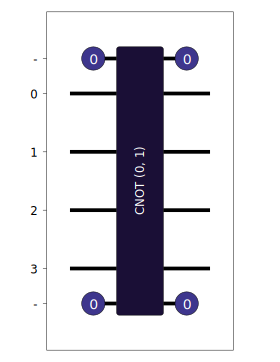

In [3]:
n_qubits = 2

cnot = qubit.CNOT()
cnot.display()

post_select = lw.PostSelection()
post_select.add((0, 1), 1)
post_select.add((2, 3), 1)

There is then a choice of algorithms that can be used for the calculation of the choi matrix for the process:
1) Linear inversion - this is a simpler algorithm with less measurements, but can produce non-physical process matrices (particularily in noisy scenarios).
2) Maximum likelihood estimation - this uses a gradient-descent based optimisation, along with a set of projections to enforce conditions for a physical process matrix.

## Linear Inversion
This method is achieved with the LIProcessTomography object. To initialise this, the number of qubits & the circuit is provided. The required experiments are then generated with ``get_experiments``, which is provided as a list of python ProcessTomographyExperiment objects.

In [4]:
li_tomo = LIProcessTomography(n_qubits, cnot)
experiments = li_tomo.get_experiments()

The experiments are then run on the target backend. For process tomography, each experiments specifies a circuit and input state to use, these should both be provided to the Sampler (or whichever task you choose).

In [5]:
backend = emulator.Backend("slos")

# Generate results and return
results = []
for exp in experiments:
    sampler = lw.Sampler(
        exp.circuit,
        exp.input_state,
        10000,
        post_selection=post_select,
        random_seed=98,
    )
    results.append(backend.run(sampler))

Finally, the choi matrix is calculated by providing this result set to the ``process`` method.

In [6]:
choi = li_tomo.process(results)

Once calculated, we plot this to view the structure of the density matrix.

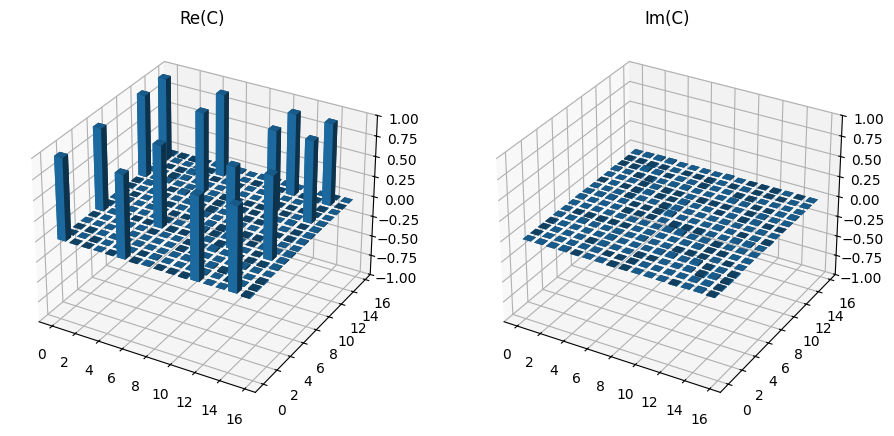

In [7]:
plot_choi_matrix(choi)
plt.show()

The choi_from_untiary function can then be used to find the expected unitary for a CNOT gate and the fidelity calculated with the relevant fidelity method. As expected this is near to 100%.

In [8]:
choi_exp = choi_from_unitary(
    [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]
)
print(f"Fidelity = {round(li_tomo.fidelity(choi_exp) * 100, 4)} %")

Fidelity = 100.425 %


## Maximum Likelihood Estimation
The pgdB algorithm from <cite data-cite="Knee_2018">(Knee_2018)</cite> is used for the projection and fitting of the choi matrix through maximum likelihood estimation.

This method is implemented using the MLEProcessTomography object and utilised in the same way as above. However, instead of looping through the experiments, we use all_circuits and all_inputs to get a list of the circuits and input states directly, which are compiled within a batch task.

In [9]:
# Create tomography object and get experiments
mle_tomo = MLEProcessTomography(n_qubits, cnot)
experiments = mle_tomo.get_experiments()

backend = emulator.Backend("slos")

# Generate results and return
batch = lw.Batch(
    lw.Sampler,
    [experiments.all_circuits, experiments.all_inputs, [10000]],
    {"post_selection": [post_select], "random_seed": [98]},
)
results = backend.run(batch)

# Find choi matrix
choi = mle_tomo.process(results)

Again, the fidelity can be calculated using the expected matrix and the results plotted to confirm the structure remains consistent.

Fidelity = 100.0035 %


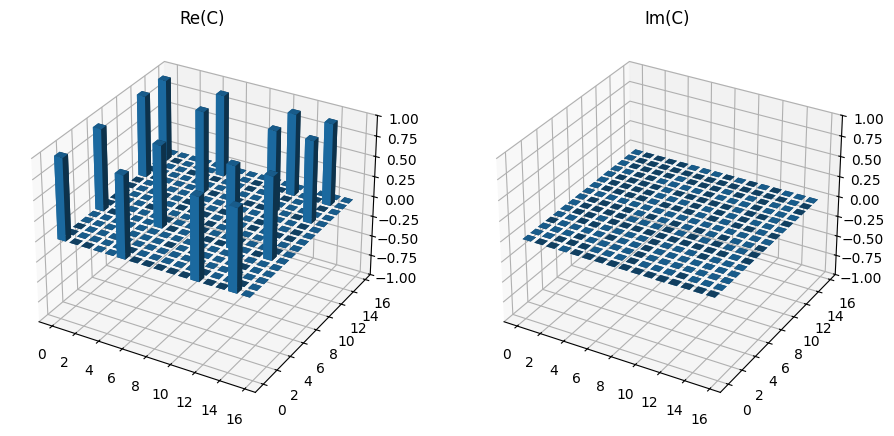

In [10]:
print(f"Fidelity = {round(mle_tomo.fidelity(choi_exp) * 100, 4)} %")

plot_choi_matrix(choi)
plt.show()

### Imperfect Experiment
As with state tomography, it is also possible to introduce imperfections into the experimental simulation, for a better understanding of how these errors affect fidelity.

For this, we'll use a class to create a parametrised experiment with optional single photon source noise and then use this for running the experiments.

In [11]:
class SamplerExperiment:
    """
    Runs experiment using the emulator Sampler for a given n_qubits with an
    optional imperfect single photon source.
    """

    def __init__(
        self, n_qubits: int, source: emulator.Source | None = None
    ) -> None:
        self.n_qubits = n_qubits
        self.source = source
        self.n_samples = 25000
        self.random_seed = 123
        self.backend = emulator.Backend("slos")

    def run(self, experiments) -> list:
        """
        Generalised version of experiment function above, designed for any
        number of qubits. It is assumes the provided circuits contain dual-rail
        encoded qubits across pairs of adjacent modes.
        """
        # Post-select on 1 photon across each pair of qubit modes
        post_select = lw.PostSelection()
        for i in range(self.n_qubits):
            post_select.add((2 * i, 2 * i + 1), 1)

        # Use a batch to run all tasks at once
        batch = lw.Batch(
            lw.Sampler,
            task_args=[
                experiments.all_circuits,
                experiments.all_inputs,
                [self.n_samples],
            ],
            task_kwargs={
                "source": [self.source],
                "post_selection": [post_select],
                "random_seed": [self.random_seed],
            },
        )
        return self.backend.run(batch)

The single photon source parameters are then configured and assigned below, setting the source indistinguishability to 95% and purity to 99%.

In [12]:
source = emulator.Source(indistinguishability=0.95, purity=0.99)

imperfect_exp = SamplerExperiment(2, source=source)

Once the tomography is performed, as expected we see a drop in fidelity and the presence of additional erroneous elements in the choi matrix.

Fidelity = 73.8299 %


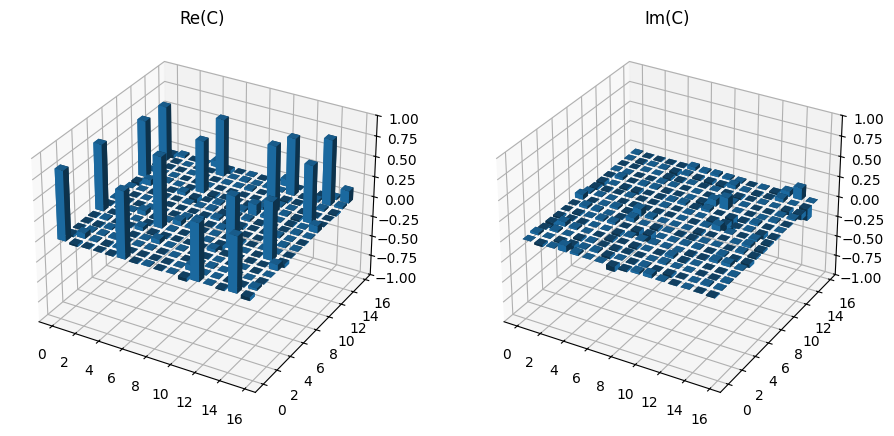

In [13]:
mle_tomo_2 = MLEProcessTomography(n_qubits, cnot)
experiments = mle_tomo_2.get_experiments()

results = imperfect_exp.run(experiments)
choi = mle_tomo_2.process(results)

print(f"Fidelity = {round(mle_tomo_2.fidelity(choi_exp) * 100, 4)} %")

plot_choi_matrix(choi)
plt.show()